# Training a machine learning model with automatic differentiation

In this tutorial we will: 

* implement a toy version of a typical machine learning setup,
* understand how automatic differentiation allows us to compute gradients of the machine learning model, and
* use automatic differentiation to train the model.

First some imports...

In [1]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

In [2]:
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
print((Y+1)//2)
Y = np.concatenate([np.zeros(50), np.ones(50)], axis=0)
print(Y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


## 1. The three basic ingredients

A machine learning problem usually consists of *data*, a *model (family)* and a *cost function*: 

<br />
<img src="figures/data-model-cost.png" width="500">
<br />

*Training* selects the best model from the family by minimising the cost on a training set of data samples. If we design the optimisation problem well, the trained model will also have a low cost on new sets of data samples that have not been used in training. This means that the model *generalises* well. 

We will now create examples for each ingredient.

### Data

Let us create a two-dimensional toy dataset.

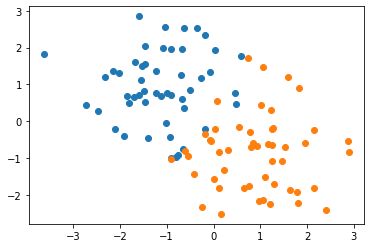

In [2]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))


plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

### Model family

Next, we construct a linear model.

In [3]:
print(X0[0])

[-0.50328585  0.8617357 ]


In [4]:
def model(x, w):
    return np.dot(x, w)

Let's try it out.

In [5]:
w = np.array([-0.5, -0.2])

model(X0[0], w)

0.07929578372862056

We can plot the decision boundary, or the boundary in data space where the model flips from a negative to a positive prediction

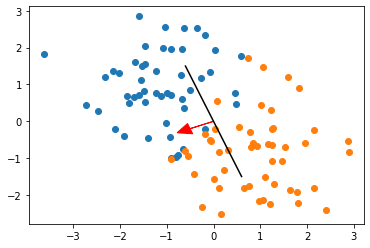

In [6]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

### Cost function

How good is the model on a single input-output training pair?

In [7]:
def loss(a, b):
    return (a - b)**2

What is the average loss on a data set of multiple pairs?

In [8]:
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w)
        c += loss(prediction, y)
    return c/len(data)

In [9]:
w = np.array([1.3, -0.4])
average_loss(w, data)

1.8504767821580002

## 2. Automatic computation of  gradients

Because we imported PennyLane's numpy version, we can now compute gradients of the average loss with respect to the weights!

In [10]:
gradient_fn = qml.grad(average_loss, argnum=0)
gradient_fn(w, data)

array([ 3.29902953, -1.94918243])

We can use gradients to guess better candidates for parameters.

In [11]:
w_new = w - 0.05*gradient_fn(w, data)

In [12]:
average_loss(w_new, data)

1.2102626825705949

This works because the gradient always points towards the steepest ascent in the cost landscape.

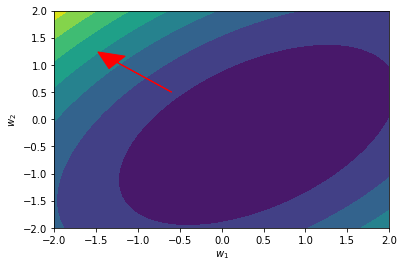

In [13]:
# compute the gradient at some point in parameter space
some_w = np.array([-0.6, 0.5])
g = 0.01*gradient_fn(some_w, data)

# make a contourplot of the cost
w1s = np.linspace(-2, 2)
w2s = np.linspace(-2, 2)
cost_grid = []
for w1 in w1s:
    for w2 in w2s:
        w = np.array([w1, w2])
        cost_grid.append(average_loss(w, data))
cost_grid = np.array(cost_grid).reshape((50, 50))
plt.contourf(w1s, w2s, cost_grid.T)

plt.arrow(some_w[0], some_w[1], some_w[0] + g[0], some_w[1] + g[1], 
          head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

## 3. Training with gradient descent

Putting it all together, we can train the linear model.

In [14]:
w_init = np.random.random(size=(2,))
w = np.array(w_init)

history = []
for i in range(15):
    w_new = w - 0.05*gradient_fn(w, data)
    print(average_loss(w_new, data))
    history.append(w_new)
    w = w_new

1.3500100407100541
1.1021852209348377
0.9290184060813584
0.8027576735134763
0.7073372523673335
0.6331673539752455
0.5743007976098509
0.5268826928791955
0.488294380852497
0.45667438524266574
0.4306452071742513
0.4091534224361
0.3913728909446769
0.3766437270037941
0.3644320177904416


We can easily visualise the path that gradient descent took in parameter space.

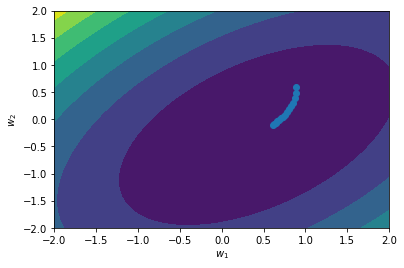

In [15]:
plt.contourf(w1s, w2s, cost_grid.T)
history = np.array(history)
plt.plot(history[:, 0], history[:, 1], "-o")
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

Training didn't fully converge yet, but the decision boundary is already better.

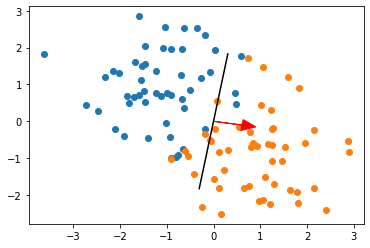

In [16]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

# TASKS 



1. Add a constant scalar bias term $b \in \mathbb{R}$ to the model,

    $$ f(x, w) = \langle w, x \rangle + b, $$

   and train both $w$ and $b$ at the same time.
   

2. Change the model to a neural network with a single hidden layer.

    $$ f(x, w, W) = \langle w, \varphi(Wx) \rangle,$$

   where $W$ is a weight matrix of suitable dimension and $\varphi$ a hand-coded nonlinar activation function. 
   
   Tipp: You can use the vector-valued sigmoid function 
   
   ```
   def sigmoid(z):
        return 1/(1 + np.exp(-x))
   ```
   

3. Code up the above example using PyTorch.

In [17]:
Y = (Y+1) / 2

In [18]:
def model(x, p):
    w, b = p
    return np.dot(x, w) + b

def average_cost(X, Y, p):
    cost = 0
    for x, y in zip(X, Y):
        pred = model(x, p)
        cost += (y - pred) ** 2
    return cost / len(X)

gradient_fn = qml.grad(average_cost, argnum=2)

In [19]:
w = np.random.random(size=(2,))
b = np.random.random(size=(1,))

p = (w, b)
stepsize = 0.05
for i in range(15):
    grad = gradient_fn(X, Y, p)
    w = w - stepsize * grad[0]
    b = b - stepsize * grad[1]
    print('cost:', average_cost(X, Y, p))
    p = (w, b)

cost: [1.07181376]
cost: [0.85089271]
cost: [0.69026819]
cost: [0.56939177]
cost: [0.47593103]
cost: [0.40219411]
cost: [0.34316991]
cost: [0.29544245]
cost: [0.25658044]
cost: [0.22478683]
cost: [0.19869187]
cost: [0.17722669]
cost: [0.15954267]
cost: [0.14495782]
cost: [0.13291939]


In [20]:
def sigmoid(z):
     return 1/(1 + np.exp(-z))

def model(x, p):
    w1, w2 = p
    layer_1 = sigmoid(np.dot(x, w1))
    return np.dot(layer_1, w2)

def average_cost(X, Y, p):
    cost = 0
    for x, y in zip(X, Y):
        pred = model(x, p)
        cost += (y - pred) ** 2
    return cost / len(X)

gradient_fn = qml.grad(average_cost, argnum=2)

In [21]:
n_features = X.shape[1]
w1 = np.random.random(size=(n_features,2))
w2 = np.random.random(size=(2,))

p = (w1, w2)
stepsize = 0.05
for i in range(15):
    grad = gradient_fn(X, Y, p)
    w1 = w1 - stepsize * grad[0]
    w2 = w2 - stepsize * grad[1]
    print('cost:', average_cost(X, Y, p))
    p = (w1, w2)

cost: 0.4547504186940483
cost: 0.43559450610409706
cost: 0.4185787581118294
cost: 0.40342431512010435
cost: 0.38989035832954494
cost: 0.3777686188417331
cost: 0.36687873614400296
cost: 0.35706432398087773
cost: 0.34818962736262365
cost: 0.3401366751551882
cost: 0.33280284940329885
cost: 0.32609880608579217
cost: 0.31994669303281464
cost: 0.31427861975197463
cost: 0.30903534131056476


In [22]:
import torch
import torch.nn as nn

In [23]:
n_features = X.shape[1]

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer_1 = nn.Linear(n_features, 2, bias=False)
        self.layer_2 = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        x = torch.sigmoid(self.layer_1(x))
        x = self.layer_2(x)
        return x

In [24]:
model = NN()

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader

In [26]:
loss = nn.MSELoss()
opt = optim.SGD(model.parameters(), lr=0.05)

In [27]:
batches = X.shape[0] // 5
batch_size = X.shape[0] // batches

X = torch.tensor(X).float()
Y = torch.tensor(Y).float()
data_loader = DataLoader(list(zip(X, Y)), batch_size=batch_size, shuffle=True)

epochs = 15
for epoch in range(epochs):
    running_cost = 0
    
    for xs, ys in data_loader:
        opt.zero_grad()
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()
        running_cost += loss_evaluated
        opt.step()
        
    avg_cost = running_cost / batches
    print("average cost per epoch {}: {:.4f}".format(epoch + 1, avg_cost))

average cost per epoch 1: 0.4747
average cost per epoch 2: 0.2878
average cost per epoch 3: 0.2610
average cost per epoch 4: 0.2534
average cost per epoch 5: 0.2487
average cost per epoch 6: 0.2502
average cost per epoch 7: 0.2483
average cost per epoch 8: 0.2492
average cost per epoch 9: 0.2469
average cost per epoch 10: 0.2490
average cost per epoch 11: 0.2473
average cost per epoch 12: 0.2499
average cost per epoch 13: 0.2449
average cost per epoch 14: 0.2475
average cost per epoch 15: 0.2479
